# Prostate epithelial transitions with scDisentangle + scVelo

This notebook computes counterfactual transitions between selected prostate time points using **scDisentangle** and visualizes them as velocity fields with **scVelo**.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import yaml

import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch

from scdisentangle.train.tools import get_trainer, set_seed

scv.set_figure_params()

# Absolute paths so the notebook is robust to working directory
BASE_DIR = "/data/Experiments/Benchmark/SCDISENTANGLE_REPRODUCE/Figures/Prostate"
DATA_PATH = "/data/Experiments/Benchmark/SCDISENTANGLE_REPRODUCE/Datasets/preprocessed_datasets/prostate.h5ad"
YAML_PATH = os.path.join(BASE_DIR, "configs", "prostate_counterfactual.yaml")
WEIGHTS_PATH = os.path.join(BASE_DIR, "counterfactual_weights", "MIG_BINNED_dis_latent_stack_time_train")

# Nice labels for time points
rename_dict = {
    'T00': 'Day 0',
    'T01_Cast_Day1': 'Castration Day 1',
    'T02_Cast_Day7': 'Castration Day 7',
    'T03_Cast_Day14': 'Castration Day 14',
    'T04_Cast_Day28': 'Castration Day 28',
    'T05_Regen_Day1': 'Regeneration Day 1',
    'T06_Regen_Day2': 'Regeneration Day 2',
    'T07_Regen_Day3': 'Regeneration Day 3',
    'T08_Regen_Day7': 'Regeneration Day 7',
    'T09_Regen_Day14': 'Regeneration Day 14',
    'T10_Regen_Day28': 'Regeneration Day 28',
}
code_to_label = rename_dict
label_to_code = {v: k for k, v in rename_dict.items()}

EPITHELIAL_L1_L2 = ["Epi_Luminal_1", "Epi_Luminal_2Psca", "Epi_Basal_1"]


In [2]:
# Load trainer from YAML via helper and attach weights

trainer = get_trainer(YAML_PATH, wandb_log=False, seed_nb=42)
print(f"Loading weights from: {WEIGHTS_PATH}")
trainer.load_weights(WEIGHTS_PATH)

# Use the same AnnData that the trainer was built on
adata_full = trainer.dataset.data.copy()
adata_full


Global seed set to 0
ic| 'Setting seed to', seed: 42
ic| 'Creating cell mappings'
ic| 'Creating inputs'
ic| 'Creating inputs'


Wandb is off
Loading weights from: /data/Experiments/Benchmark/SCDISENTANGLE_REPRODUCE/Figures/Prostate/counterfactual_weights/MIG_BINNED_dis_latent_stack_time_train
Loading weights from /data/Experiments/Benchmark/SCDISENTANGLE_REPRODUCE/Figures/Prostate/counterfactual_weights/MIG_BINNED_dis_latent_stack_time_train


AnnData object with n_obs × n_vars = 87187 × 5027
    obs: 'barcode', 'barcodeInt', 'batchID', 'highLevelPred', 'highLevelPredAmbig', 'predType', 'predTypeAmbig', 'predTypeInt', 'predTypeIntAmbig', 'time', 'n_counts', 'placeholder', 'sc_cell_ids', 'cell_ids', 'split_anndata'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'keep'
    uns: 'rank_genes_groups_time'
    layers: 'counts'

In [3]:
from scipy.sparse import issparse


def build_velocity_adata(current_time_code, future_time_code, cell_types=None, current_mode="gt"):
    """Build an AnnData object for scVelo with current/future states.

    Parameters
    ----------
    current_time_code : str
        Raw time code as in `adata_full.obs['time']` (e.g. 'T01_Cast_Day1').
    future_time_code : str
        Target time code for the counterfactual (e.g. 'T04_Cast_Day28').
    cell_types : list[str] | None
        Optional list of `predType` categories to keep (e.g. L1/L2 epithelial cells).
    current_mode : {"gt", "pred"}
        - "gt": use ground-truth expression at `current_time_code` as current state (spliced).
        - "pred": also predict the current time with scDisentangle so both
          current and future are model-based (spliced = predict(current),
          unspliced = predict(future)).

    Returns
    -------
    AnnData
        With
        - `layers['spliced']`   = current state expression
        - `layers['unspliced']` = counterfactual future expression
    """
    ad = adata_full.copy()

    mask = ad.obs["time"] == current_time_code
    if cell_types is not None:
        mask &= ad.obs["predType"].isin(cell_types)

    ad_cur = ad[mask].copy()

    # scDisentangle counterfactual prediction: map current cells to future time
    ad_future = trainer.predict(
        ad_cur.copy(),
        counterfactual_dict={"time": future_time_code},
    )

    if current_mode == "pred":
        # Also predict the current time (so both spliced and unspliced are model-based)
        ad_cur_pred = trainer.predict(
            ad_cur.copy(),
            counterfactual_dict={"time": current_time_code},
        )
        X_cur = ad_cur_pred.X.toarray() if issparse(ad_cur_pred.X) else ad_cur_pred.X.copy()
    else:
        # Use ground-truth current expression
        X_cur = ad_cur.X.toarray() if issparse(ad_cur.X) else ad_cur.X.copy()

    # Future (counterfactual) expression
    X_fut = ad_future.X.toarray() if issparse(ad_future.X) else ad_future.X.copy()

    obs = ad_cur.obs.copy()
    obs["time_current"] = obs["time"].astype(str)
    obs["time_future"] = future_time_code
    obs["time_current_label"] = obs["time_current"].map(code_to_label)
    obs["time_future_label"] = code_to_label[future_time_code]

    layers = {
        "spliced": X_cur,
        "unspliced": X_fut,
    }

    ad_scv = sc.AnnData(
        X=X_cur,
        obs=obs,
        var=ad_cur.var.copy(),
        layers=layers,
    )

    # Convenience columns for plotting
    ad_scv.obs["clusters"] = ad_scv.obs["predType"].astype("category")
    ad_scv.obs["time_label"] = ad_scv.obs["time_current_label"].astype("category")

    return ad_scv


def run_scvelo(adata_scv, n_pcs=30, n_neighbors=30):
    """Preprocess and run scVelo on a prepared velocity AnnData."""
    scv.pp.normalize_per_cell(adata_scv, enforce=True)
    scv.pp.log1p(adata_scv)
    sc.pp.highly_variable_genes(adata_scv, n_top_genes=2000, flavor="seurat_v3")
    adata_scv = adata_scv[:, adata_scv.var["highly_variable"]].copy()

    sc.tl.pca(adata_scv, n_comps=n_pcs)
    sc.pp.neighbors(adata_scv, n_neighbors=n_neighbors, n_pcs=n_pcs)
    scv.pp.moments(adata_scv, n_pcs=n_pcs, n_neighbors=n_neighbors)

    scv.tl.velocity(adata_scv, mode="deterministic")
    scv.tl.velocity_graph(adata_scv)

    sc.tl.umap(adata_scv)
    scv.tl.velocity_embedding(adata_scv, basis="umap")

    return adata_scv


In [4]:
import pandas as pd
import numpy as np
from scipy.sparse import issparse


def get_cluster_transition_df(adata, tm):
    """Aggregate cell–cell transition matrix into a cluster–cluster matrix."""
    clusters = adata.obs["clusters"].values
    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters)

    cluster_to_indices = {c: np.where(clusters == c)[0] for c in unique_clusters}

    tm = tm.A if issparse(tm) else tm
    cluster_transition = np.zeros((n_clusters, n_clusters))

    for i, source_cluster in enumerate(unique_clusters):
        source_indices = cluster_to_indices[source_cluster]
        n_source = len(source_indices)
        for j, target_cluster in enumerate(unique_clusters):
            target_indices = cluster_to_indices[target_cluster]
            total = tm[source_indices][:, target_indices].sum()
            cluster_transition[i, j] = total / max(n_source, 1)

    # Normalize rows to sum to 1
    row_sums = cluster_transition.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    cluster_transition = cluster_transition / row_sums

    cluster_transition_df = pd.DataFrame(
        cluster_transition,
        index=unique_clusters,
        columns=unique_clusters,
    )
    return cluster_transition_df


def avg_epithelial_transition_prob(cluster_tm, epithelial_clusters):
    """Average off-diagonal transition prob for selected epithelial source clusters."""
    sub = cluster_tm.loc[epithelial_clusters]
    # Zero self-transitions
    for c in epithelial_clusters:
        if c in sub.columns:
            sub.loc[c, c] = 0.0
    return float(sub.values.mean())


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 173.28it/s]
/tmp/ipykernel_978769/3977863898.py:84: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata_scv)


Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/3660 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo

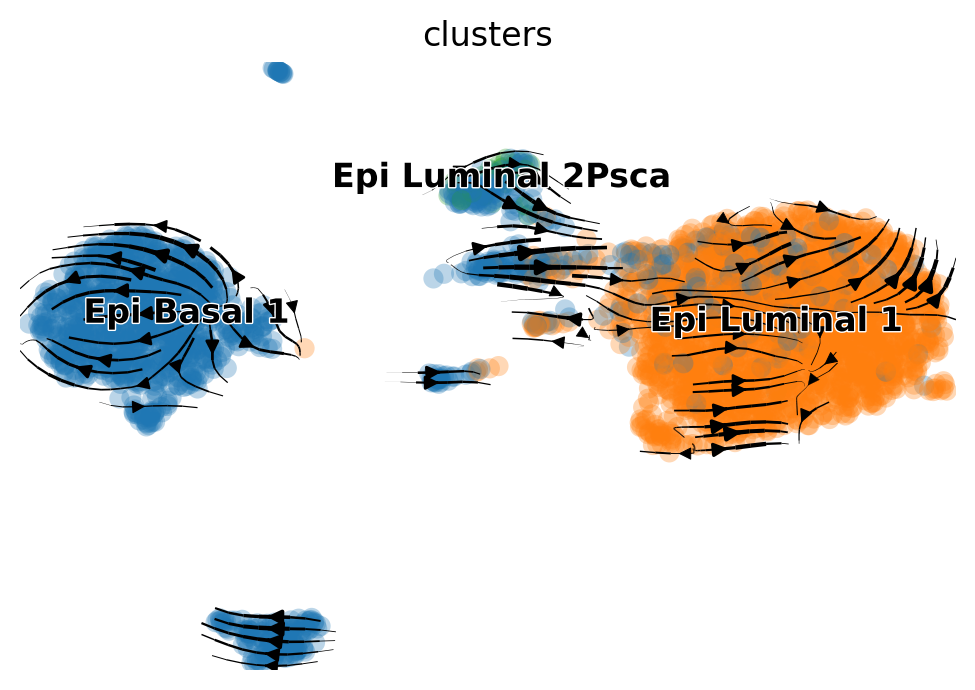

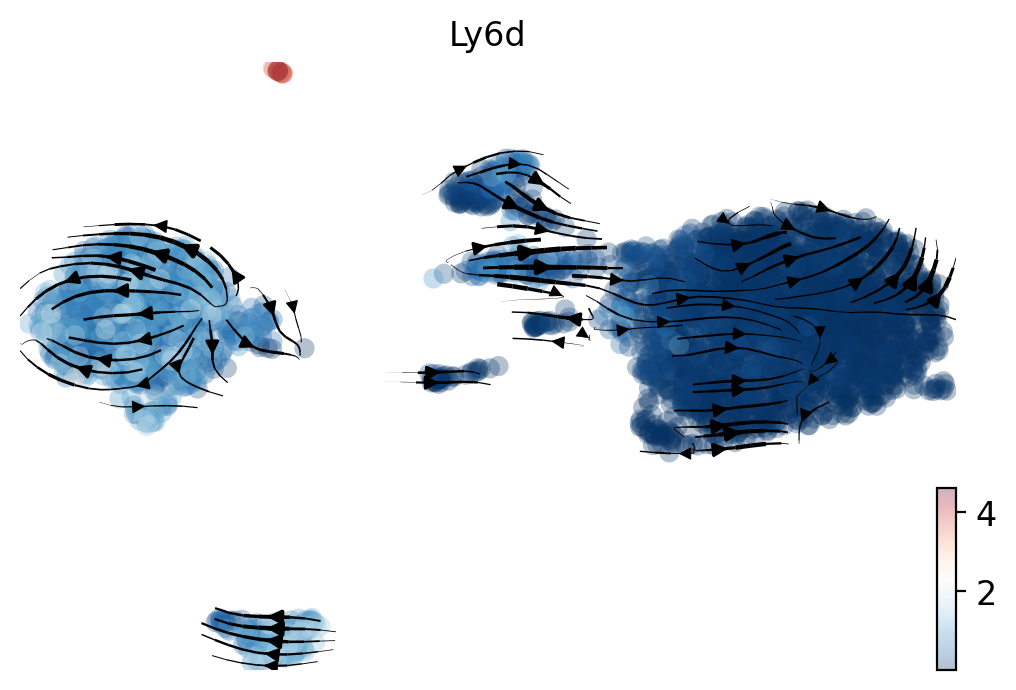

In [16]:
# Cast Day 1 → Cast Day 28: build velocity object and run scVelo

cast_current = "T03_Cast_Day14"
cast_future = "T04_Cast_Day28"

adata_cast = build_velocity_adata(
    current_time_code=cast_current,
    future_time_code=cast_future,
    cell_types=EPITHELIAL_L1_L2,
    current_mode="pred",   # or "pred" to also predict the current time
)
adata_cast = run_scvelo(adata_cast)

# Velocity map colored by epithelial subtype
scv.pl.velocity_embedding_stream(
    adata_cast,
    basis="umap",
    color="clusters",
)

# Streamline plot highlighting Ly6d expression
scv.pl.velocity_embedding_stream(
    adata_cast,
    basis="umap",
    color="Ly6d",
)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 173.57it/s]


Normalized count data: X, spliced, unspliced.


/tmp/ipykernel_978769/3977863898.py:84: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata_scv)


computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/6807 [00:00<?, ?cells/s]

    finished (0:00:21) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo

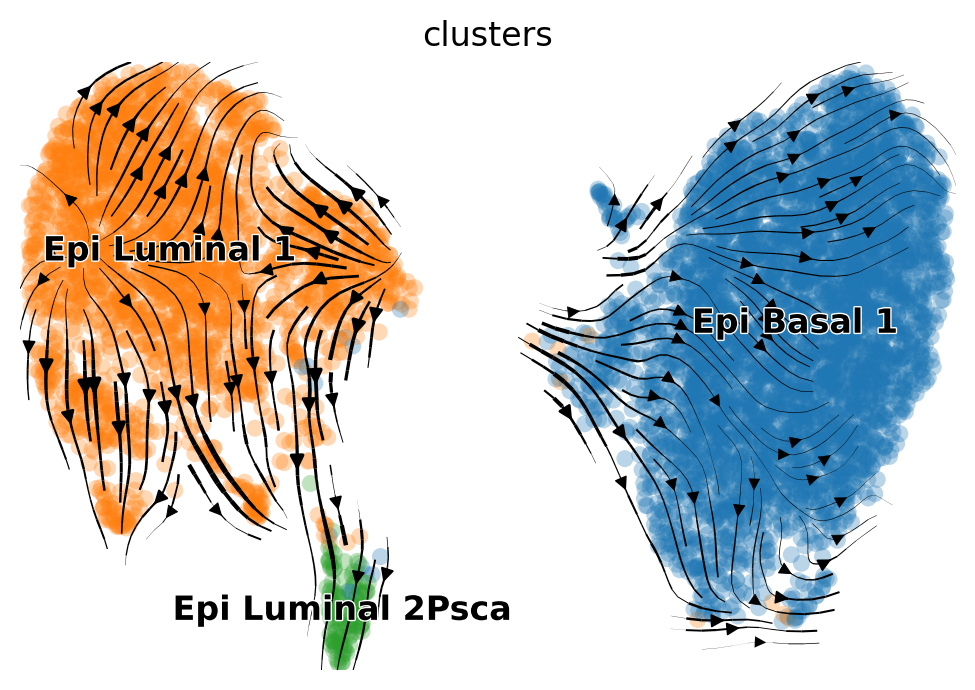

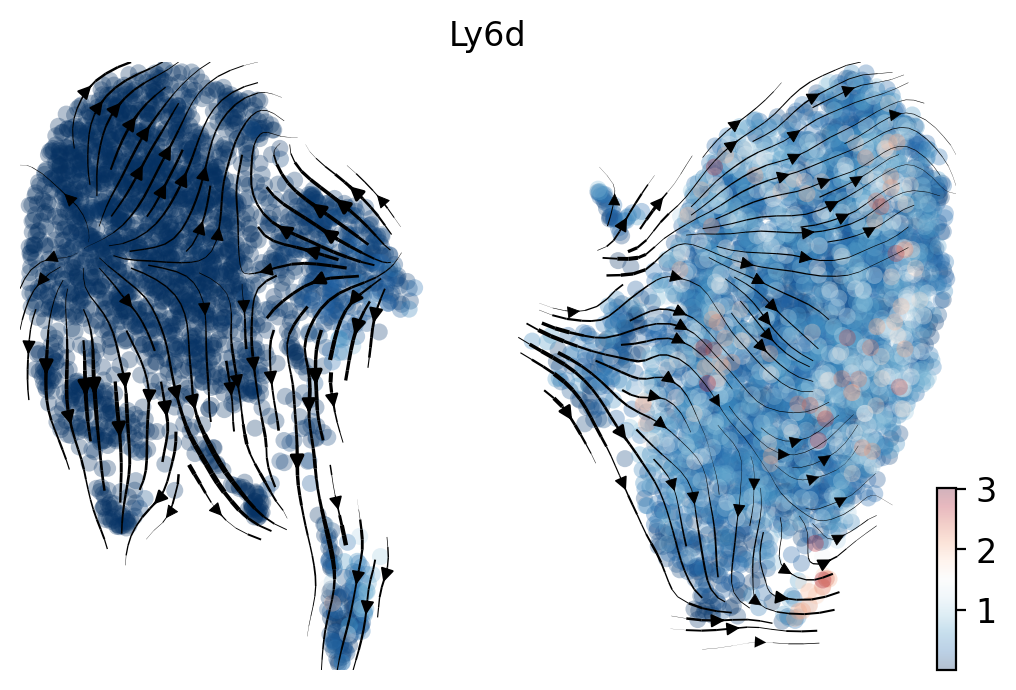

In [18]:
# Regen Day 1 → Regen Day 28: build velocity object and run scVelo

regen_current = "T09_Regen_Day14"
regen_future = "T10_Regen_Day28"

adata_regen = build_velocity_adata(
    current_time_code=regen_current,
    future_time_code=regen_future,
    cell_types=EPITHELIAL_L1_L2,
    current_mode="pred",   # or "pred" to also predict the current time
)
adata_regen = run_scvelo(adata_regen)

# Velocity map colored by epithelial subtype
scv.pl.velocity_embedding_stream(
    adata_regen,
    basis="umap",
    color="clusters",
)

# Streamline plot highlighting Ly6d expression
scv.pl.velocity_embedding_stream(
    adata_regen,
    basis="umap",
    color="Ly6d",
)


In [19]:
# Transition probabilities for epithelial L1/L2

# Cast Day1 → Cast Day28d
cast_tm = scv.utils.get_transition_matrix(adata_cast)
cast_cluster_tm = get_cluster_transition_df(adata_cast, cast_tm)
cast_avg_epithelial = avg_epithelial_transition_prob(cast_cluster_tm, EPITHELIAL_L1_L2)
print("Average L1/L2 epithelial transition probability (Cast Day1 → Day28):", cast_avg_epithelial)

# Regen Day1 → Regen Day28
regen_tm = scv.utils.get_transition_matrix(adata_regen)
regen_cluster_tm = get_cluster_transition_df(adata_regen, regen_tm)
regen_avg_epithelial = avg_epithelial_transition_prob(regen_cluster_tm, EPITHELIAL_L1_L2)
print("Average L1/L2 epithelial transition probability (Regen Day1 → Day28):", regen_avg_epithelial)

cast_avg_epithelial, regen_avg_epithelial


Average L1/L2 epithelial transition probability (Cast Day1 → Day28): 0.0906066109478239
Average L1/L2 epithelial transition probability (Regen Day1 → Day28): 0.0037720904192877778


(0.0906066109478239, 0.0037720904192877778)

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo

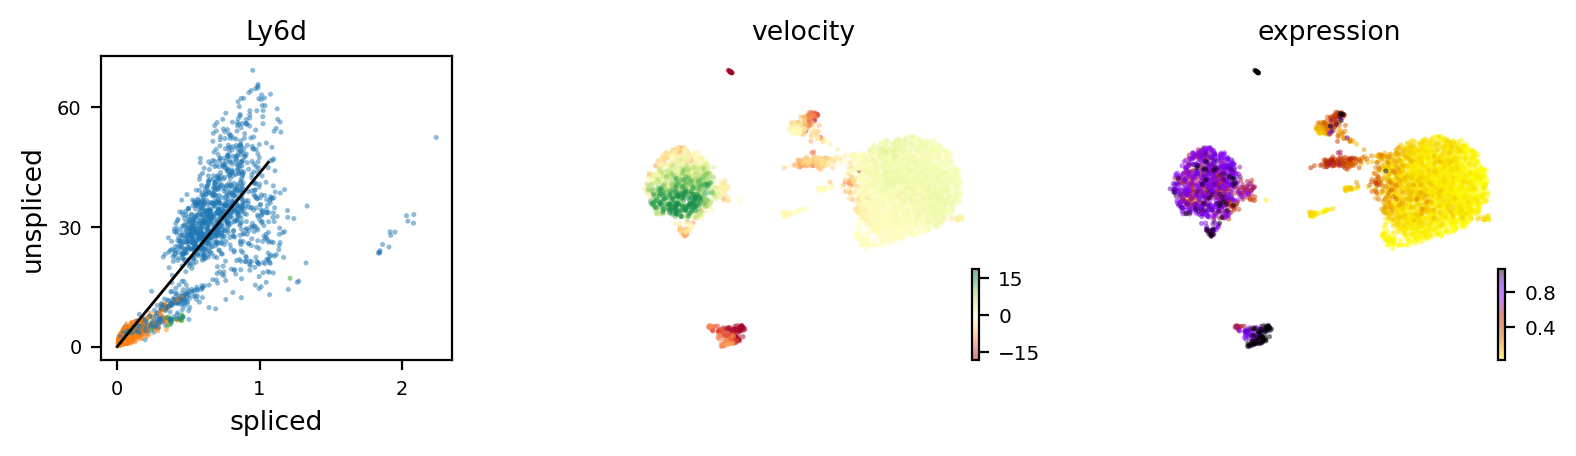

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scvelo

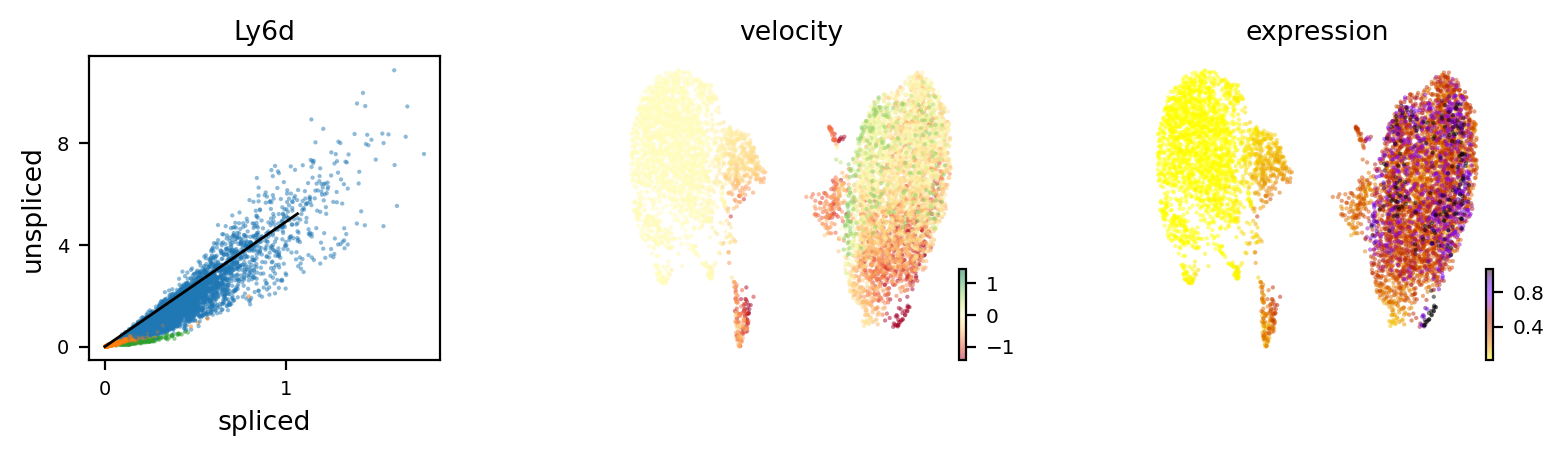

In [20]:
# Phase portraits (Ly6d) for Cast and Regen transitions

# These use layers['spliced'] (current) and layers['unspliced'] (counterfactual future)
# to show the fitted velocity for Ly6d.

scv.pl.velocity(adata_cast, "Ly6d")
scv.pl.velocity(adata_regen, "Ly6d")

